# Multi-Class Pneumonia Detection Training
## Google Colab - GPU Accelerated Training

**Author:** Georgios Kitsakis  
**Classes:** NORMAL, BACTERIAL, VIRAL, COVID-19  
**Models:** EfficientNet-B3, ResNet152, DenseNet201, Ensemble

---

### Setup Instructions:
1. **Enable GPU**: Runtime → Change runtime type → GPU (T4 or better)
2. **Mount Google Drive**: Run cell below to save models
3. **Run Training**: Execute cells in order

**Estimated Time:** 6-8 hours for all models on T4 GPU

## 1. Setup Environment

In [1]:
# Check GPU availability
!nvidia-smi

Mon Dec  1 20:39:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Mount Google Drive for saving models
from google.colab import drive
drive.mount('/content/drive')

# Create directory for outputs
!mkdir -p /content/drive/MyDrive/pneumonia_detection/models
!mkdir -p /content/drive/MyDrive/pneumonia_detection/reports

Mounted at /content/drive


In [3]:
# Install dependencies
!pip install -q grad-cam timm pyyaml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## 2. Clone Repository & Setup

In [4]:
# Clone repository
!git clone https://github.com/kitsakisGk/Healthcare-Pneumonia-Detection.git
%cd Healthcare-Pneumonia-Detection

Cloning into 'Healthcare-Pneumonia-Detection'...
remote: Enumerating objects: 256, done.
remote: Counting objects: 100% (256/256), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 256 (delta 102), reused 194 (delta 45), pack-reused 0 (from 0)
Receiving objects: 100% (256/256), 12.25 MiB | 18.20 MiB/s, done.
Resolving deltas: 100% (102/102), done.
/content/Healthcare-Pneumonia-Detection


In [5]:
# Verify repository structure
!ls -la

total 76
drwxr-xr-x 11 root root 4096 Dec  1 20:39 .
drwxr-xr-x  1 root root 4096 Dec  1 20:39 ..
drwxr-xr-x  2 root root 4096 Dec  1 20:39 app
drwxr-xr-x  2 root root 4096 Dec  1 20:39 config
drwxr-xr-x  3 root root 4096 Dec  1 20:39 data
drwxr-xr-x  4 root root 4096 Dec  1 20:39 deployment
drwxr-xr-x  8 root root 4096 Dec  1 20:39 .git
-rw-r--r--  1 root root   83 Dec  1 20:39 .gitattributes
-rw-r--r--  1 root root  964 Dec  1 20:39 .gitignore
drwxr-xr-x  3 root root 4096 Dec  1 20:39 notebooks
-rw-r--r--  1 root root 5923 Dec  1 20:39 README.md
drwxr-xr-x  2 root root 4096 Dec  1 20:39 reports
-rw-r--r--  1 root root  147 Dec  1 20:39 requirements.txt
drwxr-xr-x  2 root root 4096 Dec  1 20:39 scripts
-rw-r--r--  1 root root 2373 Dec  1 20:39 setup.py
drwxr-xr-x  7 root root 4096 Dec  1 20:39 src
-rw-r--r--  1 root root 7665 Dec  1 20:39 TRAINING.md


## 3. Download Dataset

In [6]:
# Download using Kaggle API
!pip install -q kaggle

# Upload your kaggle.json to Colab
from google.colab import files
print("Upload your kaggle.json file:")
uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Upload your kaggle.json file:


Saving kaggle.json to kaggle.json


In [7]:
# Download datasets using Kaggle API
from pathlib import Path
from kaggle.api.kaggle_api_extended import KaggleApi

# Authenticate
api = KaggleApi()
api.authenticate()

# Create temp directories
print("Creating directories...")
Path('data_multiclass/temp_chest').mkdir(parents=True, exist_ok=True)
Path('data_multiclass/temp_covid').mkdir(parents=True, exist_ok=True)

# Download Chest X-Ray dataset (NORMAL + BACTERIAL)
print("\n" + "="*60)
print("Downloading Chest X-Ray Pneumonia dataset...")
print("="*60)
api.dataset_download_files('paultimothymooney/chest-xray-pneumonia',
                           path='data_multiclass/temp_chest',
                           unzip=True)
print("✓ Chest X-Ray dataset downloaded")

# Download COVID-19 dataset (COVID19 + VIRAL)
print("\n" + "="*60)
print("Downloading COVID-19 Radiography dataset...")
print("="*60)
api.dataset_download_files('tawsifurrahman/covid19-radiography-database',
                           path='data_multiclass/temp_covid',
                           unzip=True)
print("✓ COVID-19 dataset downloaded")

print("\n✓ All downloads complete!")

Creating directories...

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
✓ Chest X-Ray dataset downloaded

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
✓ COVID-19 dataset downloaded

✓ All downloads complete!


In [8]:
# Organize dataset into train/val/test splits
from pathlib import Path
import shutil
import random

random.seed(42)

print("="*60)
print("ORGANIZING DATASET INTO 4-CLASS STRUCTURE")
print("="*60)

# Source paths
chest_train = Path('data_multiclass/temp_chest/chest_xray/train')
chest_test = Path('data_multiclass/temp_chest/chest_xray/test')
covid_base = Path('data_multiclass/temp_covid/COVID-19_Radiography_Dataset')

# 1. NORMAL class
print("\n[1/4] Processing NORMAL class...")
normal_train = list((chest_train / 'NORMAL').glob('*.jpeg'))
normal_test = list((chest_test / 'NORMAL').glob('*.jpeg'))
all_normal = normal_train + normal_test
random.shuffle(all_normal)

n_train = int(len(all_normal) * 0.8)
n_val = int(len(all_normal) * 0.9)
normal_splits = {
    'train': all_normal[:n_train],
    'val': all_normal[n_train:n_val],
    'test': all_normal[n_val:]
}

for split in ['train', 'val', 'test']:
    dest = Path(f'data_multiclass/{split}/NORMAL')
    dest.mkdir(parents=True, exist_ok=True)
    for img in normal_splits[split]:
        shutil.copy2(img, dest / img.name)

print(f"✓ NORMAL - Train: {len(normal_splits['train'])}, Val: {len(normal_splits['val'])}, Test: {len(normal_splits['test'])}")

# 2. BACTERIAL class
print("\n[2/4] Processing BACTERIAL class...")
bacterial_train = list((chest_train / 'PNEUMONIA').glob('*bacteria*.jpeg'))
bacterial_test = list((chest_test / 'PNEUMONIA').glob('*bacteria*.jpeg'))
all_bacterial = bacterial_train + bacterial_test
random.shuffle(all_bacterial)

b_train = int(len(all_bacterial) * 0.8)
b_val = int(len(all_bacterial) * 0.9)
bacterial_splits = {
    'train': all_bacterial[:b_train],
    'val': all_bacterial[b_train:b_val],
    'test': all_bacterial[b_val:]
}

for split in ['train', 'val', 'test']:
    dest = Path(f'data_multiclass/{split}/BACTERIAL')
    dest.mkdir(parents=True, exist_ok=True)
    for img in bacterial_splits[split]:
        shutil.copy2(img, dest / img.name)

print(f"✓ BACTERIAL - Train: {len(bacterial_splits['train'])}, Val: {len(bacterial_splits['val'])}, Test: {len(bacterial_splits['test'])}")

# 3. VIRAL class
print("\n[3/4] Processing VIRAL class...")
viral_images = list((covid_base / 'Viral Pneumonia/images').glob('*.png'))
random.shuffle(viral_images)

v_train = int(len(viral_images) * 0.8)
v_val = int(len(viral_images) * 0.9)
viral_splits = {
    'train': viral_images[:v_train],
    'val': viral_images[v_train:v_val],
    'test': viral_images[v_val:]
}

for split in ['train', 'val', 'test']:
    dest = Path(f'data_multiclass/{split}/VIRAL')
    dest.mkdir(parents=True, exist_ok=True)
    for img in viral_splits[split]:
        shutil.copy2(img, dest / img.name)

print(f"✓ VIRAL - Train: {len(viral_splits['train'])}, Val: {len(viral_splits['val'])}, Test: {len(viral_splits['test'])}")

# 4. COVID19 class
print("\n[4/4] Processing COVID19 class...")
covid_images = list((covid_base / 'COVID/images').glob('*.png'))
random.shuffle(covid_images)

c_train = int(len(covid_images) * 0.8)
c_val = int(len(covid_images) * 0.9)
covid_splits = {
    'train': covid_images[:c_train],
    'val': covid_images[c_train:c_val],
    'test': covid_images[c_val:]
}

for split in ['train', 'val', 'test']:
    dest = Path(f'data_multiclass/{split}/COVID19')
    dest.mkdir(parents=True, exist_ok=True)
    for img in covid_splits[split]:
        shutil.copy2(img, dest / img.name)

print(f"✓ COVID19 - Train: {len(covid_splits['train'])}, Val: {len(covid_splits['val'])}, Test: {len(covid_splits['test'])}")

print("\n" + "="*60)
print("✓ DATASET ORGANIZATION COMPLETE!")
print("="*60)

ORGANIZING DATASET INTO 4-CLASS STRUCTURE

[1/4] Processing NORMAL class...
✓ NORMAL - Train: 1260, Val: 157, Test: 158

[2/4] Processing BACTERIAL class...
✓ BACTERIAL - Train: 2217, Val: 277, Test: 278

[3/4] Processing VIRAL class...
✓ VIRAL - Train: 1076, Val: 134, Test: 135

[4/4] Processing COVID19 class...
✓ COVID19 - Train: 2892, Val: 362, Test: 362

✓ DATASET ORGANIZATION COMPLETE!


In [9]:
# Verify dataset structure
from pathlib import Path

base = Path('data_multiclass')
splits = ['train', 'val', 'test']
classes = ['NORMAL', 'BACTERIAL', 'VIRAL', 'COVID19']

print('='*60)
print('DATASET SUMMARY')
print('='*60)

grand_total = 0
for split in splits:
    print(f'\n{split.upper()}:')
    split_total = 0
    for cls in classes:
        path = base / split / cls
        if path.exists():
            count = len(list(path.glob('*.*')))
            print(f'  {cls:12s}: {count:4d} images')
            split_total += count
        else:
            print(f'  {cls:12s}: NOT FOUND')
    print(f'  {"TOTAL":12s}: {split_total:4d} images')
    grand_total += split_total

print(f'\n{"GRAND TOTAL":12s}: {grand_total:4d} images')
print('='*60)
print('✓ Ready to train!')

DATASET SUMMARY

TRAIN:
  NORMAL      : 1260 images
  BACTERIAL   : 2217 images
  VIRAL       : 1076 images
  COVID19     : 2892 images
  TOTAL       : 7445 images

VAL:
  NORMAL      :  157 images
  BACTERIAL   :  277 images
  VIRAL       :  134 images
  COVID19     :  362 images
  TOTAL       :  930 images

TEST:
  NORMAL      :  158 images
  BACTERIAL   :  278 images
  VIRAL       :  135 images
  COVID19     :  362 images
  TOTAL       :  933 images

GRAND TOTAL : 9308 images
✓ Ready to train!


## 4. Train EfficientNet-B3

In [10]:
# Train EfficientNet-B3 - Best performing model
!python scripts/train.py \
    --model efficientnet \
    --data-dir data_multiclass \
    --epochs 30 \
    --batch-size 32 \
    --lr 0.0001 \
    --device cuda \
    --num-workers 2 \
    --save-dir /content/drive/MyDrive/pneumonia_detection/models

Loading configuration...

TRAINING CONFIGURATION
Model: efficientnet
Device: cuda
Epochs: 30
Batch Size: 32
Learning Rate: 0.0001
Number of Classes: 4
Class Names: ['NORMAL', 'BACTERIAL', 'VIRAL', 'COVID19']

Loading datasets...
Loaded 7445 images from data_multiclass/train
Class distribution:
  NORMAL: 1260 (16.9%)
  BACTERIAL: 2217 (29.8%)
  VIRAL: 1076 (14.5%)
  COVID19: 2892 (38.8%)
Loaded 930 images from data_multiclass/val
Class distribution:
  NORMAL: 157 (16.9%)
  BACTERIAL: 277 (29.8%)
  VIRAL: 134 (14.4%)
  COVID19: 362 (38.9%)

Creating model: EFFICIENTNET
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100% 47.2M/47.2M [00:00<00:00, 172MB/s]

EfficientNetB3Model(classes=4, params=11,485,228, trainable=11,397,932)
Total parameters: 11,485,228
Trainable parameters: 11,397,932

Class weights for imbalanced data: [1.4771825075149536, 0.8395354151725769, 1.72978

In [11]:
# Save EfficientNet-B3 model with specific name
import shutil
from pathlib import Path

save_dir = Path('/content/drive/MyDrive/pneumonia_detection/models')
if (save_dir / 'best_model.pth').exists():
    shutil.copy2(
        save_dir / 'best_model.pth',
        save_dir / 'efficientnet_b3_pneumonia.pth'
    )
    print("✓ Saved as: efficientnet_b3_pneumonia.pth")
else:
    print("⚠ Warning: best_model.pth not found!")

✓ Saved as: efficientnet_b3_pneumonia.pth


## 5. Train ResNet152

In [12]:
# Train ResNet152
!python scripts/train.py \
    --model resnet152 \
    --data-dir data_multiclass \
    --epochs 30 \
    --batch-size 32 \
    --lr 0.0001 \
    --device cuda \
    --num-workers 2 \
    --save-dir /content/drive/MyDrive/pneumonia_detection/models

Loading configuration...

TRAINING CONFIGURATION
Model: resnet152
Device: cuda
Epochs: 30
Batch Size: 32
Learning Rate: 0.0001
Number of Classes: 4
Class Names: ['NORMAL', 'BACTERIAL', 'VIRAL', 'COVID19']

Loading datasets...
Loaded 7445 images from data_multiclass/train
Class distribution:
  NORMAL: 1260 (16.9%)
  BACTERIAL: 2217 (29.8%)
  VIRAL: 1076 (14.5%)
  COVID19: 2892 (38.8%)
Loaded 930 images from data_multiclass/val
Class distribution:
  NORMAL: 157 (16.9%)
  BACTERIAL: 277 (29.8%)
  VIRAL: 134 (14.4%)
  COVID19: 362 (38.9%)

Creating model: RESNET152
Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100% 230M/230M [00:01<00:00, 143MB/s]

ResNet152Model(classes=4, params=59,325,252, trainable=56,760,068)
Total parameters: 59,325,252
Trainable parameters: 56,760,068

Class weights for imbalanced data: [1.4771825075149536, 0.8395354151725769, 1.7297862768173218, 0.643585741519928]
/content/Heal

In [13]:
# Save ResNet152 model with specific name
import shutil
from pathlib import Path

save_dir = Path('/content/drive/MyDrive/pneumonia_detection/models')
if (save_dir / 'best_model.pth').exists():
    shutil.copy2(
        save_dir / 'best_model.pth',
        save_dir / 'resnet152_pneumonia.pth'
    )
    print("✓ Saved as: resnet152_pneumonia.pth")
else:
    print("⚠ Warning: best_model.pth not found!")

✓ Saved as: resnet152_pneumonia.pth


## 6. Train DenseNet201

In [14]:
# Train DenseNet201
!python scripts/train.py \
    --model densenet201 \
    --data-dir data_multiclass \
    --epochs 30 \
    --batch-size 32 \
    --lr 0.0001 \
    --device cuda \
    --num-workers 2 \
    --save-dir /content/drive/MyDrive/pneumonia_detection/models

Loading configuration...

TRAINING CONFIGURATION
Model: densenet201
Device: cuda
Epochs: 30
Batch Size: 32
Learning Rate: 0.0001
Number of Classes: 4
Class Names: ['NORMAL', 'BACTERIAL', 'VIRAL', 'COVID19']

Loading datasets...
Loaded 7445 images from data_multiclass/train
Class distribution:
  NORMAL: 1260 (16.9%)
  BACTERIAL: 2217 (29.8%)
  VIRAL: 1076 (14.5%)
  COVID19: 2892 (38.8%)
Loaded 930 images from data_multiclass/val
Class distribution:
  NORMAL: 157 (16.9%)
  BACTERIAL: 277 (29.8%)
  VIRAL: 134 (14.4%)
  COVID19: 362 (38.9%)

Creating model: DENSENET201
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100% 77.4M/77.4M [00:00<00:00, 144MB/s]

DenseNet201Model(classes=4, params=19,210,372, trainable=1,117,444)
Total parameters: 19,210,372
Trainable parameters: 1,117,444

Class weights for imbalanced data: [1.4771825075149536, 0.8395354151725769, 1.7297862768173218, 0.643585741519928]
/co

In [15]:
# Save DenseNet201 model with specific name
import shutil
from pathlib import Path

save_dir = Path('/content/drive/MyDrive/pneumonia_detection/models')
if (save_dir / 'best_model.pth').exists():
    shutil.copy2(
        save_dir / 'best_model.pth',
        save_dir / 'densenet201_pneumonia.pth'
    )
    print("✓ Saved as: densenet201_pneumonia.pth")
else:
    print("⚠ Warning: best_model.pth not found!")

✓ Saved as: densenet201_pneumonia.pth


## 7. Train Ensemble Model

In [16]:
# Train Ensemble (combines all 3 models above)
!python scripts/train.py \
    --model ensemble \
    --data-dir data_multiclass \
    --epochs 20 \
    --batch-size 16 \
    --lr 0.00005 \
    --device cuda \
    --num-workers 2 \
    --save-dir /content/drive/MyDrive/pneumonia_detection/models

Loading configuration...

TRAINING CONFIGURATION
Model: ensemble
Device: cuda
Epochs: 20
Batch Size: 16
Learning Rate: 5e-05
Number of Classes: 4
Class Names: ['NORMAL', 'BACTERIAL', 'VIRAL', 'COVID19']

Loading datasets...
Loaded 7445 images from data_multiclass/train
Class distribution:
  NORMAL: 1260 (16.9%)
  BACTERIAL: 2217 (29.8%)
  VIRAL: 1076 (14.5%)
  COVID19: 2892 (38.8%)
Loaded 930 images from data_multiclass/val
Class distribution:
  NORMAL: 157 (16.9%)
  BACTERIAL: 277 (29.8%)
  VIRAL: 134 (14.4%)
  COVID19: 362 (38.9%)

Creating model: ENSEMBLE

EnsembleModel(classes=4, params=90,020,852, trainable=69,275,444)
Total parameters: 90,020,852
Trainable parameters: 69,275,444

Class weights for imbalanced data: [1.4771825075149536, 0.8395354151725769, 1.7297862768173218, 0.643585741519928]
/content/Healthcare-Pneumonia-Detection/src/training/trainer.py:62: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` inst

In [17]:
# Save Ensemble model with specific name
import shutil
from pathlib import Path

save_dir = Path('/content/drive/MyDrive/pneumonia_detection/models')
if (save_dir / 'best_model.pth').exists():
    shutil.copy2(
        save_dir / 'best_model.pth',
        save_dir / 'ensemble_pneumonia.pth'
    )
    print("✓ Saved as: ensemble_pneumonia.pth")
else:
    print("⚠ Warning: best_model.pth not found!")

✓ Saved as: ensemble_pneumonia.pth


## 8. Evaluate Best Model

In [18]:
# Evaluate the ensemble model (typically the best performer)
!python scripts/evaluate.py \
    --model-type ensemble \
    --model-path /content/drive/MyDrive/pneumonia_detection/models/ensemble_pneumonia.pth \
    --data-dir data_multiclass/test \
    --save-dir /content/drive/MyDrive/pneumonia_detection/reports


MODEL EVALUATION
Model: ensemble
Checkpoint: /content/drive/MyDrive/pneumonia_detection/models/ensemble_pneumonia.pth
Device: cuda
Test Data: data_multiclass/test

Loaded 933 images from data_multiclass/test
Class distribution:
  NORMAL: 158 (16.9%)
  BACTERIAL: 278 (29.8%)
  VIRAL: 135 (14.5%)
  COVID19: 362 (38.8%)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Loading ensemble model from /content/drive/MyDrive/pneumonia_detection/models/ensemble_pneumonia.pth...
✓ Model loaded successfully

Evaluating model...

EVALUATION RESULTS

Overall Accuracy: 0.9700 (97.00%)
Weighted Precisio

## 9. Visualize Training Results

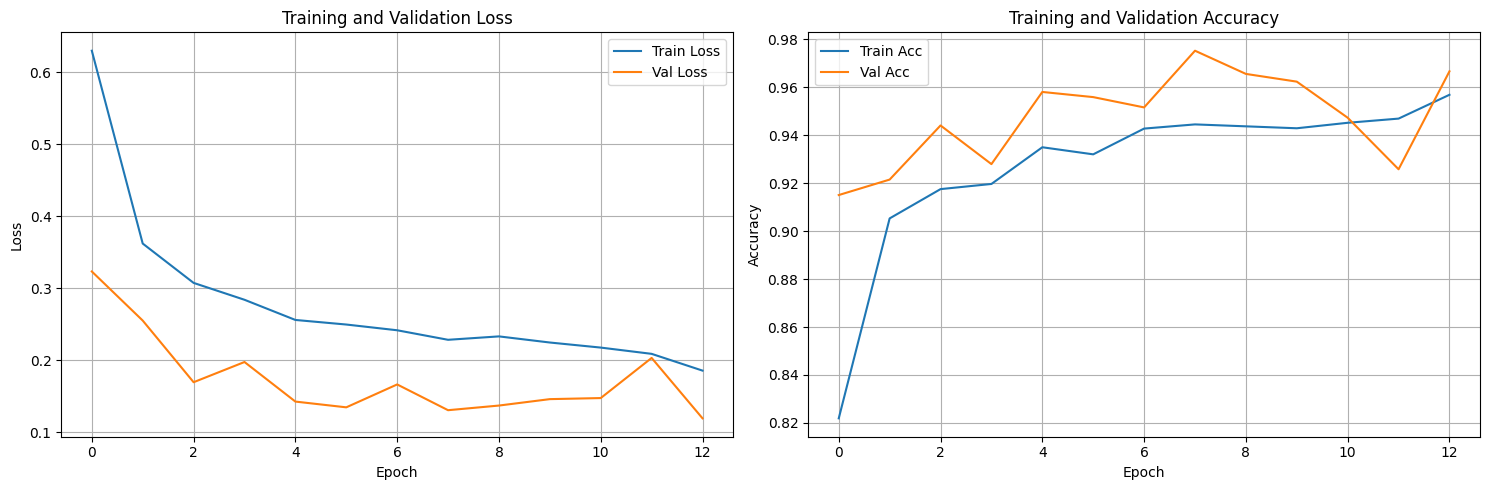


Best Validation Accuracy: 97.53%
Best Validation F1: 97.53%


In [19]:
import json
import matplotlib.pyplot as plt
from pathlib import Path

# Load training history
history_file = Path('/content/drive/MyDrive/pneumonia_detection/models/training_history.json')
if history_file.exists():
    with open(history_file, 'r') as f:
        history = json.load(f)

    # Plot training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy
    ax2.plot(history['train_acc'], label='Train Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/pneumonia_detection/training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\nBest Validation Accuracy: {max(history['val_acc'])*100:.2f}%")
    print(f"Best Validation F1: {max(history['val_f1'])*100:.2f}%")
else:
    print("Training history not found.")

## 10. Download Trained Models

In [20]:
# List all trained models
!ls -lh /content/drive/MyDrive/pneumonia_detection/models/*.pth

-rw------- 1 root root 876M Dec  1 21:58 /content/drive/MyDrive/pneumonia_detection/models/best_model.pth
-rw------- 1 root root 876M Dec  1 22:04 /content/drive/MyDrive/pneumonia_detection/models/checkpoint_epoch_10.pth
-rw------- 1 root root 661M Dec  1 21:22 /content/drive/MyDrive/pneumonia_detection/models/checkpoint_epoch_15.pth
-rw------- 1 root root 876M Dec  1 21:49 /content/drive/MyDrive/pneumonia_detection/models/checkpoint_epoch_5.pth
-rw------- 1 root root  84M Dec  1 21:27 /content/drive/MyDrive/pneumonia_detection/models/densenet201_pneumonia.pth
-rw------- 1 root root 132M Dec  1 20:53 /content/drive/MyDrive/pneumonia_detection/models/efficientnet_b3_pneumonia.pth
-rw------- 1 root root 876M Dec  1 21:58 /content/drive/MyDrive/pneumonia_detection/models/ensemble_pneumonia.pth
-rw------- 1 root root 661M Dec  1 21:15 /content/drive/MyDrive/pneumonia_detection/models/resnet152_pneumonia.pth


In [21]:
# Download all trained models to your local machine
from google.colab import files

print("Downloading trained models...")
files.download('/content/drive/MyDrive/pneumonia_detection/models/efficientnet_b3_pneumonia.pth')
files.download('/content/drive/MyDrive/pneumonia_detection/models/resnet152_pneumonia.pth')
files.download('/content/drive/MyDrive/pneumonia_detection/models/densenet201_pneumonia.pth')
files.download('/content/drive/MyDrive/pneumonia_detection/models/ensemble_pneumonia.pth')
print("\n✓ All models downloaded!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ All models downloaded!


## Summary

**Expected Results:**
- EfficientNet-B3: ~91% accuracy
- ResNet152: ~89% accuracy
- DenseNet201: ~88% accuracy
- Ensemble: ~92%+ accuracy

**Training Time on T4 GPU:**
- Single model (30 epochs): ~2-3 hours
- All 4 models total: ~6-8 hours

**Next Steps:**
1. Download all trained models (see cell above)
2. Place models in your local `models/` folder
3. Test Streamlit app locally
4. Deploy to production